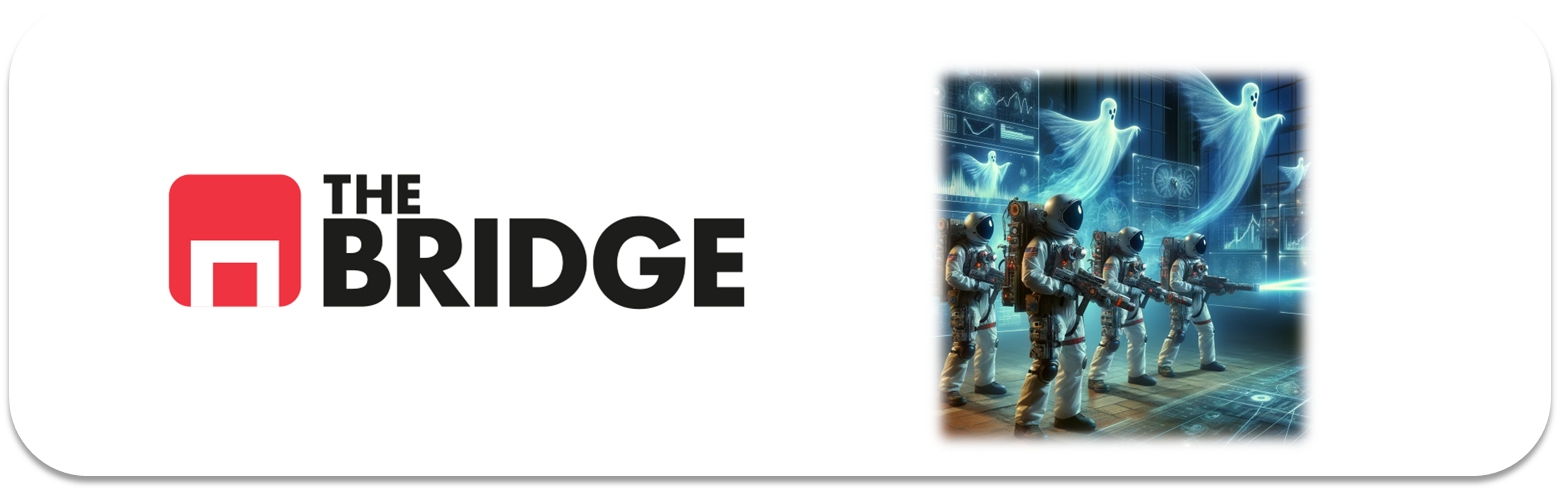

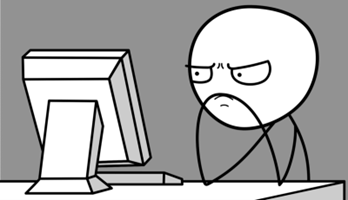

Para ejercitarte y afianzar lo aprendido sobre **Series Temporales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### El "problema"

Para este ejercicio vamos a predecir cuál será la demanda de pasajeros de una aerolinea, para poder anticiparse a las contrataciones de personal, mantenimiento de las aeronaves y gestión de inventario y comidas.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, mean_squared_error

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Ejercicio 1

Carga los datos y adecúa el dataset teniendo en cuenta que es una serie temporal. Para ello convierte la columna de fecha al formato adecuado y luego úsala como índice.

In [85]:
df = pd.read_csv('./data/AirPassengers.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)
df

,value
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


### Ejercicio 2

¿De qué fecha a qué fecha va el histórico?¿Qué periodicidad tiene la serie?

Va de `1949/01/01` hasta `1960/12/01`. La serie tiene una periodicidad mensual.

In [86]:
origin, last = '1949-01-01', '1960-12-01'

### Ejercicio 3

¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad? Analiza de manera gráfica, pero todavía sin descomponer la serie.

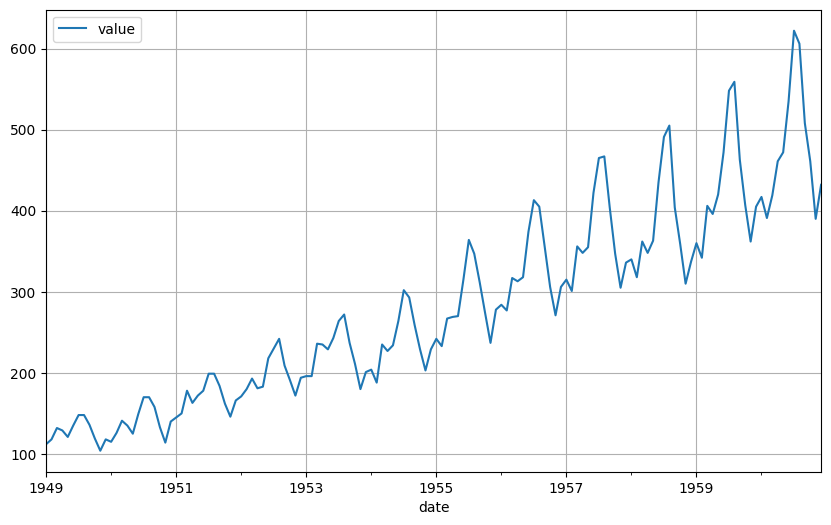

In [87]:
df[origin:last].plot(grid=True)
plt.show()

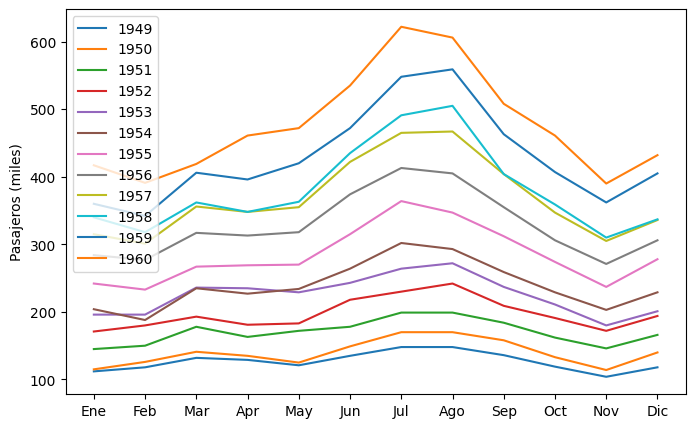

In [88]:
fig,axes = plt.subplots(1,1,figsize = (8,5), sharex = True)
for year in range(1949,1961):
    axes.plot(df.loc[f"{year}"]["value"].values, label = year)
plt.legend()
plt.ylabel("Pasajeros (miles)")
plt.xticks(ticks = range(0,12), labels = ["Ene","Feb","Mar","Apr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"]);

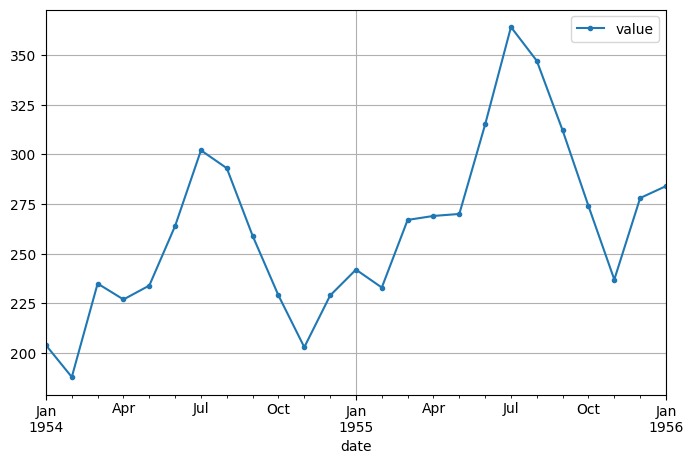

In [89]:
df['1954-01-01':'1956-01-01'].plot(grid=True, marker=".", figsize=(8,5))
plt.show()

#### Tendencia

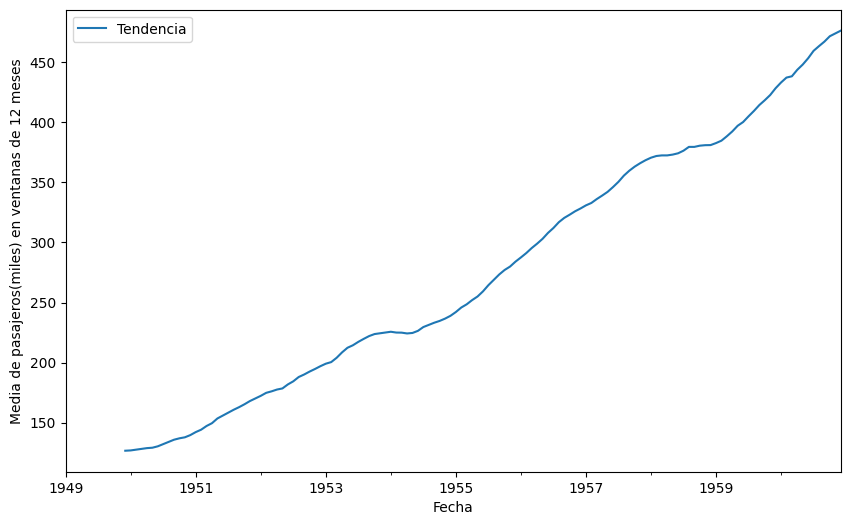

In [90]:
df.rolling(12).mean().rename(columns = {'value':'Tendencia'}).plot()
plt.xlabel("Fecha")
plt.ylabel("Media de pasajeros(miles) en ventanas de 12 meses");

Tiene una tendencia creciente conforme va avanzando el tiempo. Cada vez la diferencia entre el punto más alto de un periodo y el más bajo es mayor. Los picos son en los meses de verano. Aumenta de manera exponencial

### Ejercicio 4

¿Podrías demostrar de dos maneras estadísticas que la serie no es estacionaria?

Primero método: Extrayendo tendencia y estacionalidad.

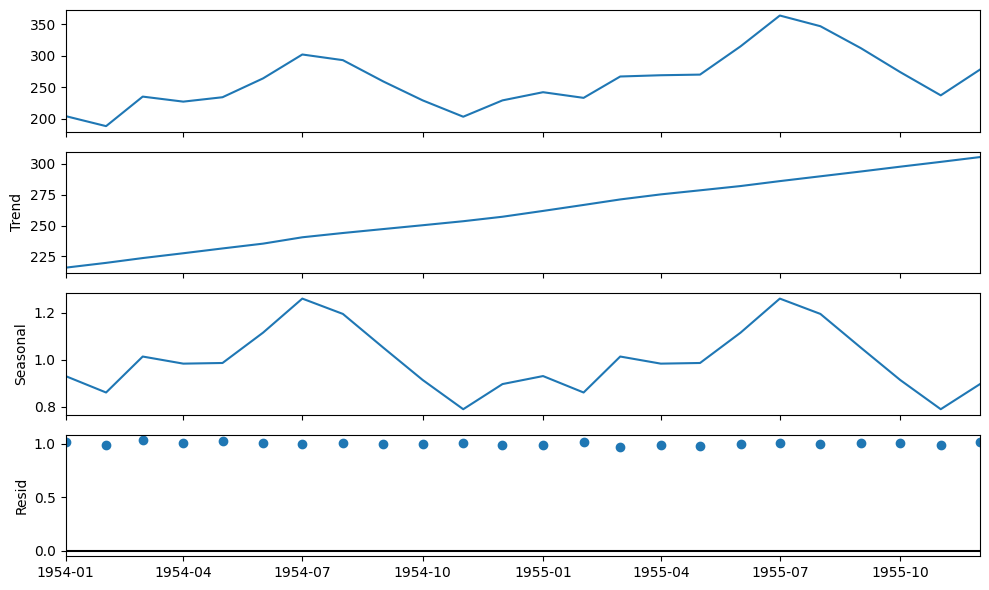

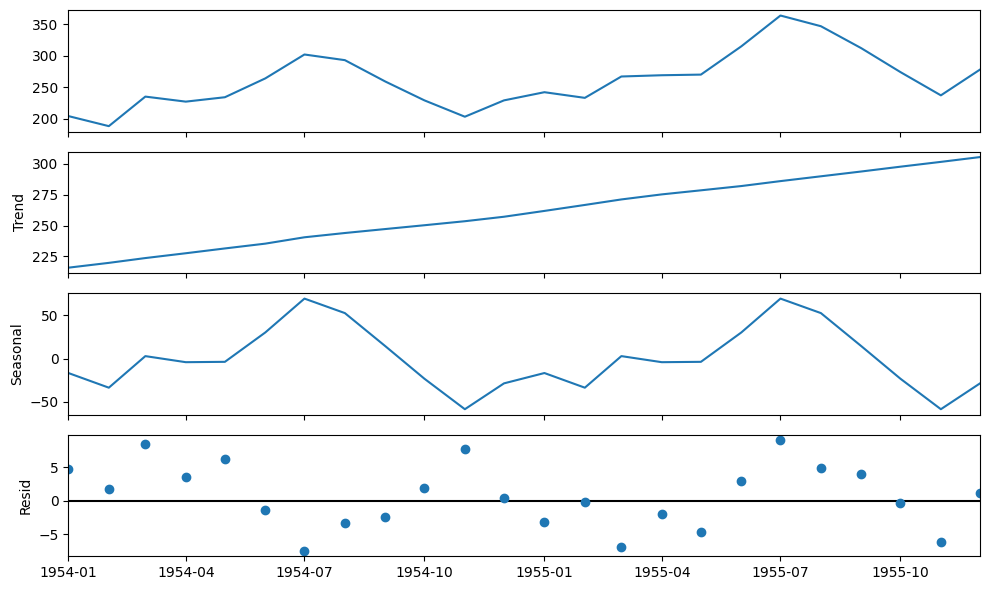

In [91]:
result_mul = seasonal_decompose(df["1954":"1955"], model = 'multiplicative', extrapolate_trend = 'freq')

# Additive Decomposition
result_add = seasonal_decompose(df["1954":"1955"], model = 'additive', extrapolate_trend = 'freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,6)})
result_mul.plot()
result_add.plot();

Existe una tendencia y una estacionalidad claras. Por lo que es `NO estacionario`

Segundo método: Test de hipótesis (test de Dickey-Fuller Aumenatdo o ADFuller)

In [92]:
result = adfuller(df.values)
print('p-value obtenido:', result[1])

p-value obtenido: 0.991880243437641


In [93]:
result = adfuller(df.diff(12)["1955":"1956"].values)
print('p-value obtenido:', result[1])

p-value obtenido: 0.7062141371947426


Obtenemos un `p-value` superior a 0.05, por lo que no podemos rechazar la hipótesis nula. La serie `no es estacionaria`

### Ejercicio 5

Emplea la descomposición que hemos aprendido en el workout para representar gráficamente la tendencia. Si has mostrado gráficamente la tendencia en el ejercicio 3, compara ambos.

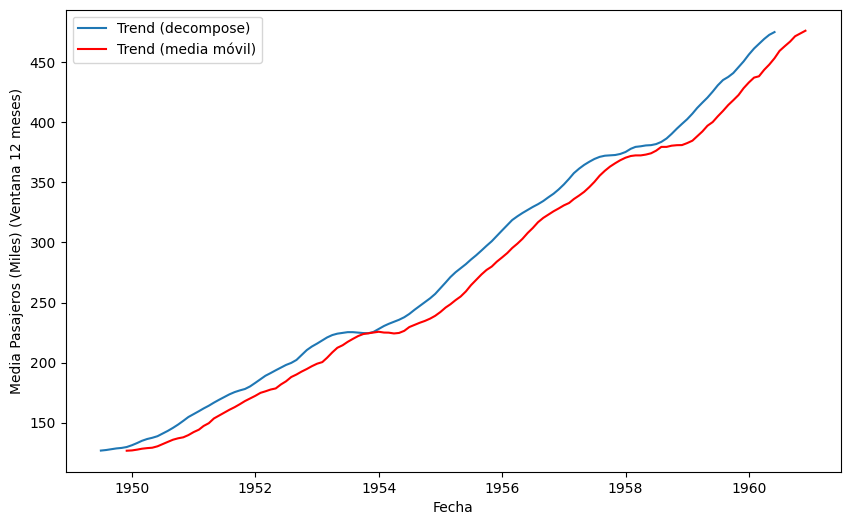

In [94]:
result_multi = seasonal_decompose(df['value'], model='multiplicative', period=12)
plt.plot(result_multi.trend, label = "Trend (decompose)");
plt.plot(df.rolling(12).mean().rename(columns = {"value": "tendencia"}), color = "red", label = "Trend (media móvil)")
plt.xlabel("Fecha")
plt.ylabel("Media Pasajeros (Miles) (Ventana 12 meses)")
plt.legend();

### Ejercicio 6

Visualiza todos los componentes de la serie temporal por separado

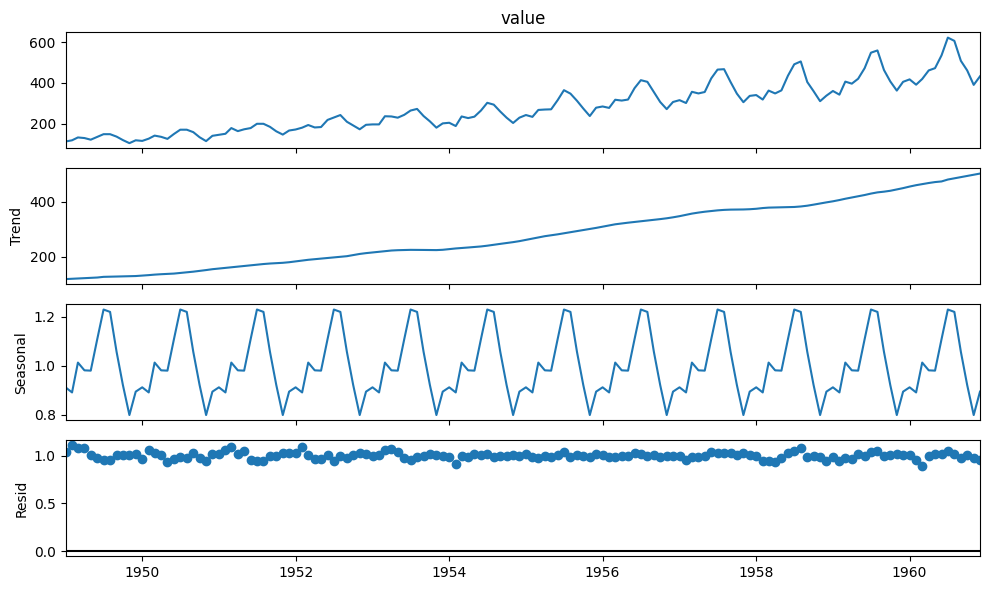

In [95]:
result_mul = seasonal_decompose(df['value'], model = 'multiplicative', extrapolate_trend = 'freq')
fig = result_mul.plot()
plt.show()

### Ejercicio 7

Crea una matriz de correlación con los últimos 24 instantes (matriz de autocorrelación). Crea un dataframe con shift de 1 a 24 para ello, la idea es que puedas hacer una matriz de correlación con el valor actual y los 24 valores anteriores. Es decir de un mes con sus 23 meses anteriores. Interpreta la estacionalidad

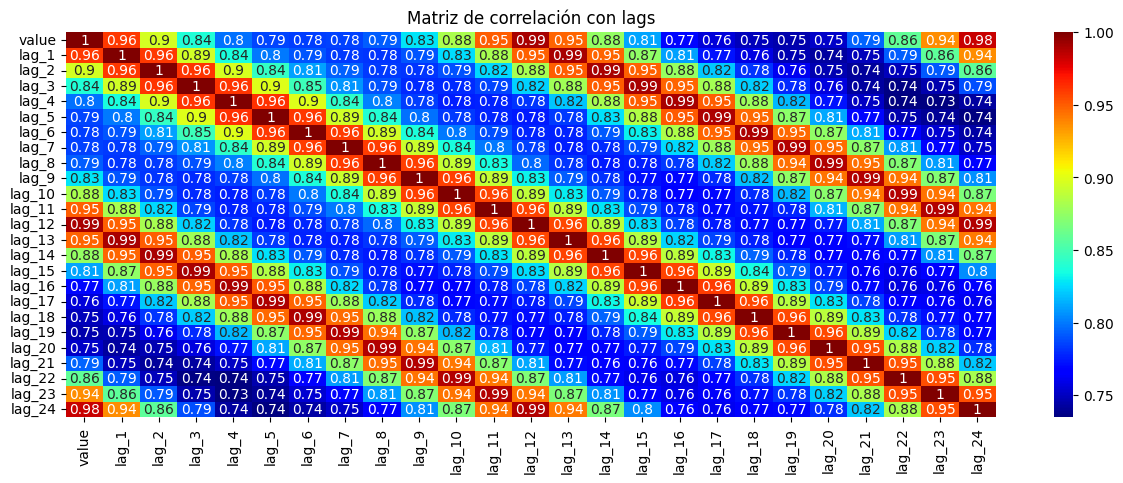

In [96]:
df_autocorr = df.copy()

for lag in range(1,25):
    df_autocorr[f'lag_{lag}'] = df_autocorr['value'].shift(lag)

# Cálculo de la matriz de autocorrelación
correlation_matrix = df_autocorr[['value'] + [f'lag_{lag}' for lag in range(1, 25)]].corr()

plt.figure(figsize=(15,5))
sns.heatmap(correlation_matrix, annot=True, cmap='jet')
plt.title('Matriz de correlación con lags')
plt.show()

Las correlaciones vs value (el valor actual), cada 12 instantes se observa un aumento de correlación, por ejemplo la correlación actual crece con el lag 12 y con el lag 24, esto indica una estacionalidad cada 12 instantes o anual en este caso. Básicamente la estacionalidad es esa autocorrelación que existe en una serie entre periodos equivalentes, en este caso los meses de enero correlan con los meses de enero. En el caso de tener una estacionalidad semanal (no para este dataset) entonces lo que correlarían sería los datos de cada día de la semana (como lo que correlan son los datos de la serie temporal consigo misma, por eso se le denomina autocorrelación y toda serie de valores que tenga "Periodos" repetidos muestra autocorrelación

### Ejercicio 8
Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?

Se cumple cada 12 meses (12, 24, 36, ...). Hay una estacionalidad anual

### Ejercicio 9

 Divide en train y test. En este caso no haremos división en validación, entre otras razones por la cantidad de datos que tenemos. Guarda 20 muestras para test.

In [97]:
train_set = df['value'].iloc[:124]
test_set = df['value'].iloc[124:]

### Ejercicio 10

Pon en práctica lo visto en clases, crea un modelo de ARIMA (puedes utilizar autoarima), mide su RMSE y su MAPE. Comparalo gráficamente con los valores reales.

In [109]:
from pmdarima.arima import ARIMA

#1 sin auto-arima
import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))
pdq[:10]
results = []
for param in pdq:
    try:
        model_arima = ARIMA(order=param)
        model_arima_fit = model_arima.fit(train_set)
        results.append((param,model_arima_fit.aic()))
    except:
        continue
resultados_df = pd.DataFrame(results, columns=['ARIMA params', 'AIC']).sort_values('AIC')
resultados_df.head()

,ARIMA params,AIC
83,"(3, 1, 3)",1119.169869
114,"(4, 2, 4)",1125.127423
108,"(4, 1, 3)",1127.981782
34,"(1, 1, 4)",1133.726935
107,"(4, 1, 2)",1134.574565


RMSE: 77.2147863862299
MAPE: 10.78%


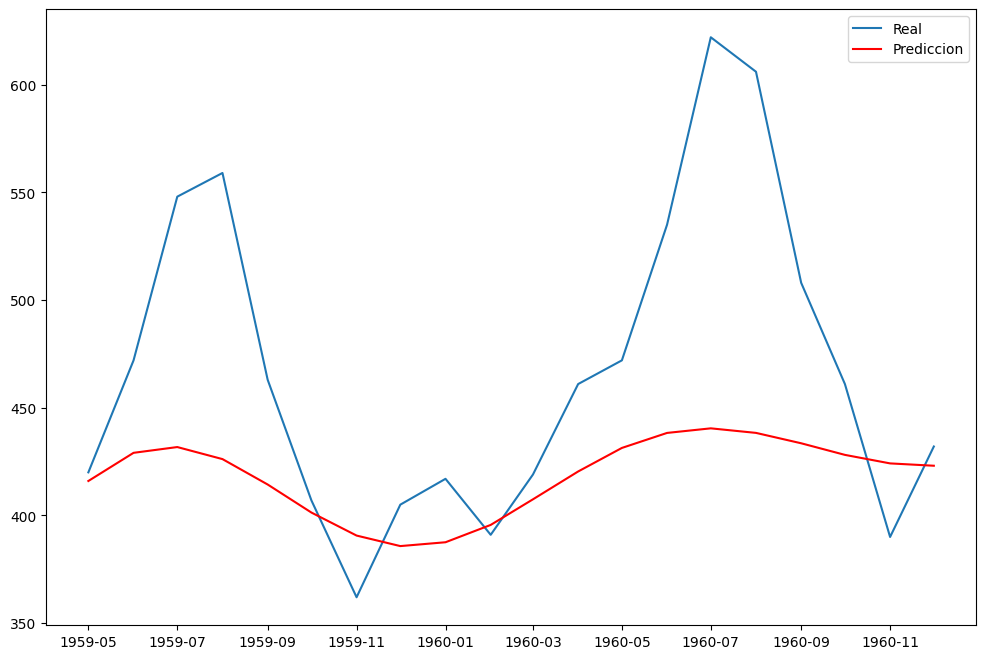

In [112]:
model_arima = ARIMA(order = (3,1,3))
model_arima.fit(train_set)
# Resultados
predictions_1 = model_arima.predict(20) 
error_rmse = np.sqrt(mean_squared_error(test_set, predictions_1))
error_mape = mean_absolute_percentage_error(test_set, predictions_1)
print(f'RMSE: {error_rmse}')
print(f"MAPE: {round(error_mape * 100,2)}%")

# Plot
plt.figure(figsize = (12,8))
plt.plot(test_set, label = "Real")
plt.plot(predictions_1, color='red', label = "Prediccion")
plt.legend();

### Ejercicio 11

Haz lo mismo que en el ejercicio 10 pero con un modelo SARIMA. ¿Cuál es mejor y por qué?

In [113]:
from pmdarima.arima import auto_arima

model_auto_sar = auto_arima(train_set,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    m = 12, # frecuencia de estacionalidad anual
                    trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=942.581, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=841.692, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=890.316, Time=0.19 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1100.615, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=841.349, Time=0.07 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=841.921, Time=0.14 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=841.844, Time=0.08 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=842.275, Time=0.08 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=889.425, Time=0.07 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=842.600, Time=0.21 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=849.916, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,1,0)[12] intercept
Total fit time: 2.491 seconds


RMSE: 30.673685879922207
MAPE: 5.86%


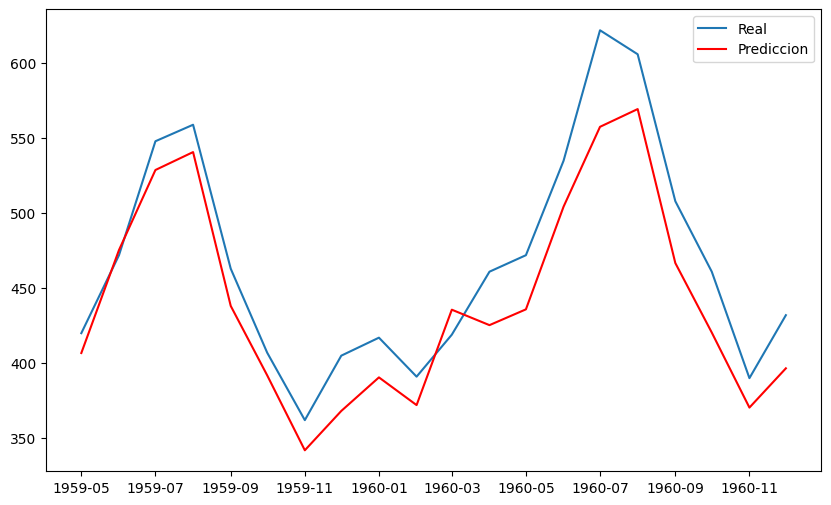

In [114]:
predictions_2 = model_auto_sar.predict(20)
error_rmse = np.sqrt(mean_squared_error(test_set, predictions_2))
error_mape = mean_absolute_percentage_error(test_set, predictions_2)
print(f'RMSE: {error_rmse}')
print(f"MAPE: {round(error_mape * 100,2)}%")

plt.plot(test_set, label = "Real")
plt.plot(predictions_2, color='red', label = "Prediccion")
plt.legend();
